<a href="https://colab.research.google.com/github/anosharahim/capstone/blob/master/fer_dimensionality_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Mount colab on gdrive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


# Import libraries and packages

In [ ]:
# Preprocessing
import pandas as pd
import os
import imageio
import numpy as np
import random 

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as plt_io
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline

# Machine Learning
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

!pip install umap-learn
import umap.umap_ as umap

#get TSNE CUDA to run on GPU
!pip install tsnecuda
!pip install -q condacolab

import condacolab
condacolab.install()

!wget https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda101.tar.bz2
!tar xvjf tsnecuda-2.1.0-cuda101.tar.bz2
!cp -r site-packages/* /usr/local/lib/python3.7/dist-packages/
!conda install --offline tsnecuda-2.1.0-cuda101.tar.bz2

from tsnecuda import TSNE as TSNE_CUDA

## Load Data

In [78]:
#Load training data 

train_npz = np.load("/content/drive/MyDrive/Capstone/datasets/train.npz")

x_train = train_npz["arr_0"]
y_train = train_npz["arr_1"]

print('Training Samples=' , x_train.shape, ',  Training Labels=', y_train.shape)

Training Samples= (28709, 48, 48) ,  Training Labels= (28709,)


# PCA: Principal Component Analysis


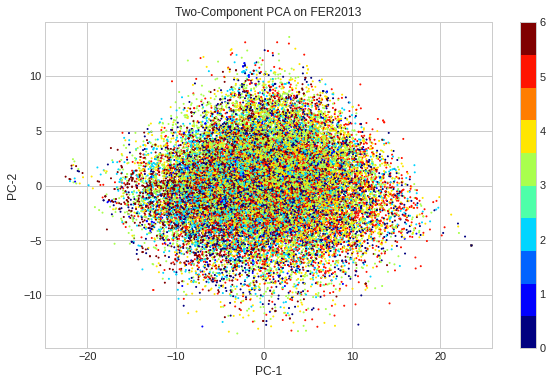

In [117]:
x_train_reshaped = x_train.reshape(len(x_train),48*48)
#rescale to standardize the input to avoid biased results 
scaler = MinMaxScaler()
train_rescaled = scaler.fit_transform(x_train_reshaped)

#Two-Component PCA
pca_ = PCA(n_components=2)
pca_ = pca_.fit_transform(train_rescaled)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)

plt.scatter(pca_[:, 0], pca_[:, 1], s = 1, cmap = c_map , c = y_train) 
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.show()

In [10]:
#Three-Component PCA
pca_3d = PCA(n_components=3)
pca_3d = pca_3d.fit_transform(train_rescaled)

In [11]:
#plot 3 components 
def plot_3d(component1,component2,component3):
    
    fig = go.Figure(data=[go.Scatter3d(
        x=component1,
        y=component2,
        z=component3,
        mode='markers',
        showlegend=True,
        marker=dict(
            size=2,
            color=y_train,      # set color to an array/list of desired values
            colorscale='Rainbow',   # choose a colorscale
            opacity=1,
            line_width=1
        ),  
    )])
    # tight layout
    fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=1800,height=1000)
    fig.layout.template = 'plotly_white'
    fig.show()

plt.ioff()
plot_3d(pca_3d[:, 0],pca_3d[:, 1],pca_3d[:, 2])

<iframe src="https://drive.google.com/file/d/1pNUHHIPQytvXkrzFZ4-0dbtW_cc8Xo39/preview" width="640" height="480" allow="autoplay"></iframe>

In [131]:
pca = PCA()
pca.fit(x_train_reshaped)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "Number of Components", "y": "Explained Variance"}
)

#TSNE: T-distributed Stochastic Neighbor Embedding (T-SNE)

#### 1. What is T-SNE? 


TSNE is a non-linear dimensionality reduction algorithm proposed by Laurens van der Maaten specifically for the purpose of visualizing high dimensional datapoints. During the learning process, T-SNE minimizes for the KL-Divergence loss using gradient descent optimization:   

$L = \Sigma_{i,j}p_{ij}\log\frac{p_{ij}}{q_{ij
}}$

First, TSNE constructs a probability distribution $p_{ij}$ over pairs of datapoints in high dimensional space, with high probability for nearer datapoints and lower probability for farther datapoints. A similar probability distribution $q_{ij}$ is defined for the low dimensional space, and the difference between these probabilities is minimized using the loss function with respect to their locations in high-dim and low-dim map. 

#### 2. Hyperparameter Tuning

I conducted the TSNE learning on PCA components of the original dataset that constitutes 90% of the variance. The GPU version of TSNE has random initialization. In order to improve the visualizations and separate the clusters, I tuned the following hyperparameters in various ways: 

**Early Exaggeration**

If at the beginning of learning, the repulsive forces are too strong that clusters of datapoints form prematurely and continue to separate in that way, it can result in a local minimum where a cluster is distributed unevenly across the 2D space. In order to overcome this and prevent the loss function from converging to a local minimum, early exaggeration spikes up the attractive forces in the early learning process, which ensures that pieces of a cluster clump together early on to prevent local minimum convergence. Increasing early exaggeration too much resulted in sparse visualization with no clustering, whereas smaller values would produce dense plots with no useful clustering. 

**Perplexity**

Perplexity roughly sets the number of nearest neighbors that enter the loss function. Smaller values of perplexity are rarely useful because it does't allow for too many neighbors to be attracted, whereas very large perplexity values are not helpful either because it takes too many neighbors into accoutn for computing similarity, which can be computationally heavy. The usual values for perplexity are between 5 and 50, but TSNE has robust responses to different values of perplexity so I tuned this mostly by trial and error. 

**Learning Rate**

The learning rate determines the size of one step of the gradient updates. I experimented with different numbers between 10 and 500. The best values for learning rate were between 50 and 100.


**Iterations**

The default number of iterations in sklearn is about 1000, but I increased this number to 10,000 and even 100,000 to improve learning. 


In [56]:
pca_ = PCA(n_components = .90)
pca_ = pca_.fit_transform(x_train_reshaped)

In [129]:
#Hyperparameters 

e = 1000 #early exaggeration
p = 80 #perplexity
n = 100000 #no. of iterations 
lr = 300 #learning rate

tsne = TSNE_CUDA(n_components=2, learning_rate=lr, perplexity = p, early_exaggeration= e, n_iter=n) #(n_components=2, verbose=0)
TSNE_features = tsne.fit_transform(pca_)

a = TSNE_features[:,0]
b = TSNE_features[:,1]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



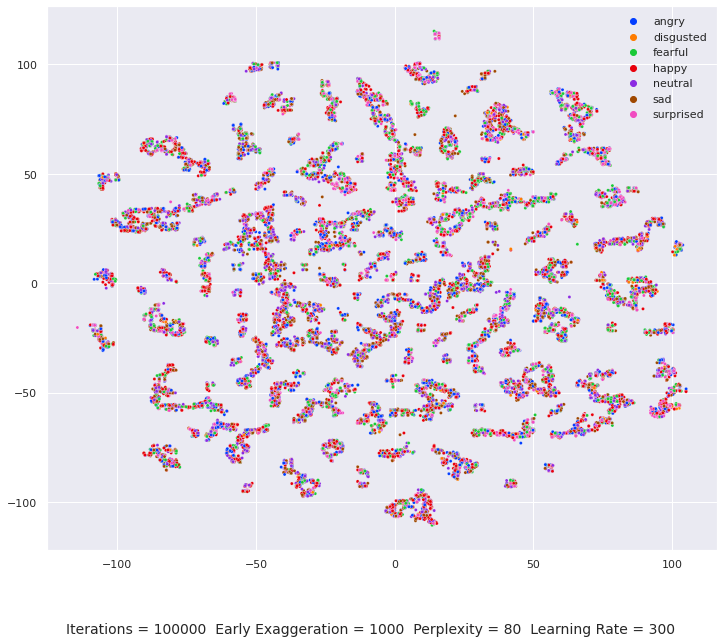

In [130]:
s_plot = sns.scatterplot(a,b, hue=y_train , legend='full', s=10, palette = 'bright')

#get emotion labels from categorical encoding
handles, labels  =  s_plot.get_legend_handles_labels()
s_plot.legend(handles, ['angry','disgusted','fearful','happy','neutral','sad','surprised'], loc='upper right')

#plot title 
txt= "Iterations = {}  Early Exaggeration = {}  Perplexity = {}  Learning Rate = {}".format(n,e,p,lr)
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)
sns.set(rc={'figure.figsize':(12,10)})